### Building a basic chatbot using LangSmith and LangGraph.

In [1]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import StateGraph,START,END
from langgraph.graph.message import add_messages

In [2]:
class State(TypedDict):
    messages:Annotated[list,add_messages]
graph_build=StateGraph(State)
graph_build

In [3]:
# In cell 3, update the .env loading and add API key validation
import os 
from dotenv import load_dotenv
from getpass import getpass

# Load .env file
load_dotenv()

# Check if GROQ_API_KEY exists and is valid
if not os.getenv("GROQ_API_KEY"):
    print("GROQ_API_KEY not found in .env file")
    api_key = getpass("Please enter your Groq API key: ")
    os.environ["GROQ_API_KEY"] = api_key
else:
    print("GROQ_API_KEY found in .env file")
    
# Verify the API key is not empty
if not os.getenv("GROQ_API_KEY") or len(os.getenv("GROQ_API_KEY")) < 20:
    print("⚠️  API key appears to be invalid or too short")

GROQ_API_KEY found in .env file


In [4]:
from langchain_groq import ChatGroq
from langchain.chat_models import init_chat_model
llm=ChatGroq(model="llama-3.3-70b-versatile")


c:\Users\adity\miniconda3\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
# llm = init_chat_model("groq:llama-3.3-70b-versatile")
llm

ChatGroq(profile={'max_input_tokens': 131072, 'max_output_tokens': 32768, 'image_inputs': False, 'audio_inputs': False, 'video_inputs': False, 'image_outputs': False, 'audio_outputs': False, 'video_outputs': False, 'reasoning_output': False, 'tool_calling': True}, client=<groq.resources.chat.completions.Completions object at 0x00000197D967A270>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x00000197D967AF90>, model_name='llama-3.3-70b-versatile', model_kwargs={}, groq_api_key=SecretStr('**********'))

In [6]:
def chatbot(state: State):
    try:
        response = llm.invoke(state["messages"])
        return {"messages": [response]}
    except Exception as e:
        print(f"Error calling Groq API: {e}")
        from langchain_core.messages import AIMessage
        return {"messages": [AIMessage(content=f"Error: {str(e)}")]}

In [7]:
# Build the graph
# Adding the nodes
graph_build.add_node("llmchatbot",chatbot)
graph_build.add_edge(START,"llmchatbot")
graph_build.add_edge("llmchatbot",END)
# compile the graph_build
graph=graph_build.compile()

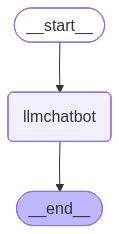

In [8]:
from IPython.display import display,Image
try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception as e:
    print("Error displaying graph:", e)

In [9]:
response=graph.invoke({"messages":"hi"})
response['messages'][-1].content
for event in graph.stream({"messages":"hi"}):
    # print(event['messages'][-1].content)
    for value in event.values():
        print(value["messages"][-1].content)

It's nice to meet you. Is there something I can help you with or would you like to chat?


# Building with External Tools
# Tavily Tool


In [15]:
from langchain_tavily import TavilySearch
tool=TavilySearch(max_result=2)
tool=[tool]

In [16]:
llm_with_tools = llm.bind_tools(tool)

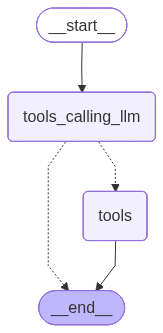

In [17]:
from langgraph.graph import StateGraph,START,END
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition
def tool_calling_llm(state:State):
    return{"messages":[llm_with_tools.invoke(state["messages"])]}
# defination
builder=StateGraph(State)
builder.add_node("tools_calling_llm", tool_calling_llm)
builder.add_node("tools",ToolNode(tool))
# add edges
builder.add_edge(START,"tools_calling_llm")
# conditional edges
builder.add_conditional_edges(
    "tools_calling_llm",
    tools_condition
)
builder.add_edge("tools",END)
# compile the graph
graph=builder.compile()
display(Image(graph.get_graph().draw_mermaid_png()))


In [18]:
response=graph.invoke({"messages":"what is the  recenct blockchain news"})

In [19]:
response['messages'][-1].content
for m in response['messages']:
    m.pretty_print()

================================ Human Message =================================

what is the  recenct blockchain news
================================== Ai Message ==================================
Tool Calls:
  tavily_search (mgzc7nkcw)
 Call ID: mgzc7nkcw
  Args:
    query: recent blockchain news
    time_range: day
    topic: news
================================= Tool Message =================================
Name: tavily_search

{"query": "recent blockchain news", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://www.bitget.com/amp/news/detail/12560605197799", "title": "This week’s mining data: Bitcoin mining difficulty sees the largest single downward adjustment since summer 2021; Cango raises an additional $75.5 million, focusing on transformation to an AI distributed computing power platform. - Bitget", "score": 0.5983122, "published_date": "Fri, 13 Feb 2026 04:01:52 GMT", "content": "This week’s mining data: Bitcoin mining difficulty see

In [20]:
response=graph.invoke({"messages":"what is the latest tech news"})
for m in response['messages']:
    m.pretty_print()

================================ Human Message =================================

what is the latest tech news
================================== Ai Message ==================================
Tool Calls:
  tavily_search (5yrnfdbjg)
 Call ID: 5yrnfdbjg
  Args:
    query: latest tech news
    search_depth: basic
    time_range: day
    topic: news
================================= Tool Message =================================
Name: tavily_search

{"query": "latest tech news", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://www.cnbc.com/2026/02/13/tech-download-newsletter-ai-capex-hyperscalers.html", "title": "The Tech Download: Can hyperscalers justify their huge AI capex? - CNBC", "score": 0.40356684, "published_date": "Fri, 13 Feb 2026 12:12:39 GMT", "content": "The Tech Download: Can hyperscalers justify their huge AI capex? # The Tech Download: Can hyperscalers justify their huge AI capex? NEWSLETTERThe Tech Download: Can hyperscalers justify 

# REACT AGENT  ARCHTITECUTRE

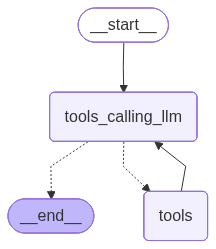

In [21]:
from langgraph.graph import StateGraph,START,END
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition
def tool_calling_llm(state:State):
    return{"messages":[llm_with_tools.invoke(state["messages"])]}
# defination
builder=StateGraph(State)
builder.add_node("tools_calling_llm", tool_calling_llm)
builder.add_node("tools",ToolNode(tool))
# add edges
builder.add_edge(START,"tools_calling_llm")
# conditional edges
builder.add_conditional_edges(
    "tools_calling_llm",
    tools_condition
)
builder.add_edge("tools","tools_calling_llm")
# compile the graph
graph=builder.compile()
display(Image(graph.get_graph().draw_mermaid_png()))


In [22]:
response=graph.invoke({"messages":"what is the latest tech news"})
for m in response['messages']:
    m.pretty_print()

================================ Human Message =================================

what is the latest tech news
================================== Ai Message ==================================
Tool Calls:
  tavily_search (b0d9xz5s5)
 Call ID: b0d9xz5s5
  Args:
    query: latest tech news
    time_range: day
    topic: news
================================= Tool Message =================================
Name: tavily_search

{"query": "latest tech news", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://www.investopedia.com/stock-market-today-dow-jones-s-and-p-500-02122026-11905226", "title": "Stock Market Today: Major Indexes Drop on Tech Stock Sell-Off; Dow Sheds 500 Points; AppLovin, Cisco Plunge After Earnings - Investopedia", "score": 0.49611887, "published_date": "Thu, 12 Feb 2026 17:24:28 GMT", "content": "# Stock Market Today: Major Indexes Drop on Tech Stock Sell-Off; Dow Sheds 500 Points; AppLovin, Cisco Plunge After Earnings. Markets News, 

ADDING MEMORY IN AGENTIC AI

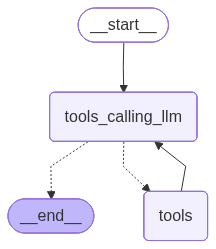

In [23]:
from langgraph.graph import StateGraph,START,END
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition
from langgraph.checkpoint.memory import MemorySaver
memory=MemorySaver()
def tool_calling_llm(state:State):
    return{"messages":[llm_with_tools.invoke(state["messages"])]}
# defination
builder=StateGraph(State)
builder.add_node("tools_calling_llm", tool_calling_llm)
builder.add_node("tools",ToolNode(tool))
# add edges
builder.add_edge(START,"tools_calling_llm")
# conditional edges
builder.add_conditional_edges(
    "tools_calling_llm",
    tools_condition
)
builder.add_edge("tools","tools_calling_llm")
# compile the graph
graph=builder.compile(checkpointer=memory)
display(Image(graph.get_graph().draw_mermaid_png()))

In [25]:
config={"configurable":{"thread_id":"1"}}
response=graph.invoke({"messages":"Hi my name is Elliot"},config=config)
response

{'messages': [HumanMessage(content='Hi my name is Elliot', additional_kwargs={}, response_metadata={}, id='80176267-46be-4d30-a845-4523f62bf969'),
  AIMessage(content="Hello Elliot, it's nice to meet you. Is there something I can help you with or would you like to chat?", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 26, 'prompt_tokens': 1687, 'total_tokens': 1713, 'completion_time': 0.083040738, 'completion_tokens_details': None, 'prompt_time': 0.086800955, 'prompt_tokens_details': None, 'queue_time': 0.048770445, 'total_time': 0.169841693}, 'model_name': 'llama-3.3-70b-versatile', 'system_fingerprint': 'fp_68f543a7cc', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None, 'model_provider': 'groq'}, id='lc_run--019c577e-b389-7682-a0b3-cd427d4227d9-0', tool_calls=[], invalid_tool_calls=[], usage_metadata={'input_tokens': 1687, 'output_tokens': 26, 'total_tokens': 1713})]}

In [26]:
response['messages'][-1].content

"Hello Elliot, it's nice to meet you. Is there something I can help you with or would you like to chat?"

STREAMING

In [27]:
from langgraph.checkpoint.memory import MemorySaver
memory=MemorySaver()

In [28]:
def superbot(state:State):
    return({"messages":[llm.invoke(state['messages'])]})

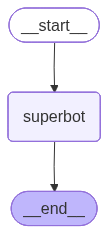

In [29]:
graph=StateGraph(State)
graph.add_node("superbot",superbot)
graph.add_edge(START,"superbot")
graph.add_edge("superbot",END)
graph_builder=graph.compile(checkpointer=memory)
display(Image(graph_builder.get_graph().draw_mermaid_png()))

In [30]:
config={"configurable":{"thread_id":"1"}}
graph_builder.invoke({"messages":"Hi There"},config)

{'messages': [HumanMessage(content='Hi There', additional_kwargs={}, response_metadata={}, id='4ffb0c8e-92e9-467f-82a5-16bb2e635e77'),
  AIMessage(content="It's nice to meet you. Is there something I can help you with or would you like to chat?", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 23, 'prompt_tokens': 37, 'total_tokens': 60, 'completion_time': 0.051542345, 'completion_tokens_details': None, 'prompt_time': 0.001689865, 'prompt_tokens_details': None, 'queue_time': 0.049654571, 'total_time': 0.05323221}, 'model_name': 'llama-3.3-70b-versatile', 'system_fingerprint': 'fp_68f543a7cc', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None, 'model_provider': 'groq'}, id='lc_run--019c577e-ea9a-7642-8986-53cea363d188-0', tool_calls=[], invalid_tool_calls=[], usage_metadata={'input_tokens': 37, 'output_tokens': 23, 'total_tokens': 60})]}

In [31]:
config={"configurable":{"thread_id":"1"}}
for c in graph_builder.invoke({"messages":"Hi There"},config,stream_mode='updates'):
    print(c)
    

{'superbot': {'messages': [AIMessage(content="Hello again. Is everything okay? You seem to be repeating yourself. Would you like to start a conversation or is there something on your mind that you'd like to talk about? I'm here to listen and help if I can.", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 48, 'prompt_tokens': 71, 'total_tokens': 119, 'completion_time': 0.15008605, 'completion_tokens_details': None, 'prompt_time': 0.006720933, 'prompt_tokens_details': None, 'queue_time': 0.049735187, 'total_time': 0.156806983}, 'model_name': 'llama-3.3-70b-versatile', 'system_fingerprint': 'fp_68f543a7cc', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None, 'model_provider': 'groq'}, id='lc_run--019c577e-f2d6-70f1-ac40-a2c5f5ef365c-0', tool_calls=[], invalid_tool_calls=[], usage_metadata={'input_tokens': 71, 'output_tokens': 48, 'total_tokens': 119})]}}
